In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from tqdm import tqdm

In [2]:
from PIL import Image

path = "./imgs/task13/spider.jpg"
image = Image.open(path)

size = min(image.size)
k = int(size / 100)

image = np.array(image.resize((size, size)))
 
# kernel parameters
k_border = 2 * k
k_size = 2 * k_border + 1

# cupy and numpy kernels
np_kernel = np.ones((k_size,k_size)) # square kernel for numpy
np_kernel /= np_kernel.sum() # values normalization
cp_kernel = cp.array(np_kernel) # same kernel as for numpy

image.shape, np_kernel.shape, cp_kernel.shape

((265, 265, 3), (9, 9), (9, 9))

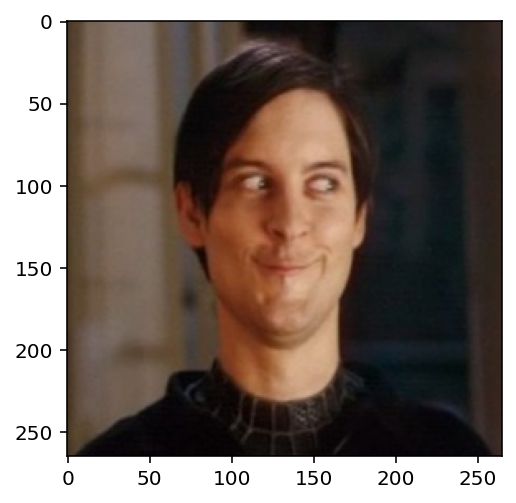

In [3]:
plt.imshow(image);

In [4]:
# blur function (input parted image, kernel, input array type)
def np_blur(parted_image, kernel):
    kernel = np.ravel(kernel) # squeeze to 1 dimension
    out = np.dot(parted_image, kernel) # multiplication with kernel
    out = np.reshape(out, (size, size)) # reshape into initial size
    return out

def cp_blur(parted_image, kernel):
    kernel = cp.ravel(kernel)
    out = cp.dot(parted_image, kernel)
    out = cp.reshape(out, (size, size))
    return out


def break_image(img):
    size = img.shape[0]
    channels = img.shape[-1]
    k = int(size / 100)
    # kernel parameters
    k_border = 2 * k
    k_size = 2 * k_border + 1

    np_parted_image = np.zeros((size * size, k_size * k_size, channels), dtype='float32')
    # for all pixels (i,j) exсept borders, for each channel (r, g, b)
    for i in range(k_border, size - k_border):
        for j in range(k_border, size - k_border):
            # pack arrays into one dimension
            # consequtevly save each kernel into array size*size, k_size,k_size
            np_parted_image[i * size + j] = img[i - k_border:i + k_border + 1, j - k_border:j + k_border + 1].reshape(-1, channels)
    return np_parted_image

In [5]:
# divide image into parts
np_parted_image = break_image(image)
cp_parted_image = cp.array(np_parted_image)


np_blurred = np.stack([np_blur(np_parted_image[..., i], np_kernel) for i in range(3)], axis=-1)
cp_blurred = cp.stack([cp_blur(cp_parted_image[..., i], cp_kernel) for i in range(3)], axis=-1)

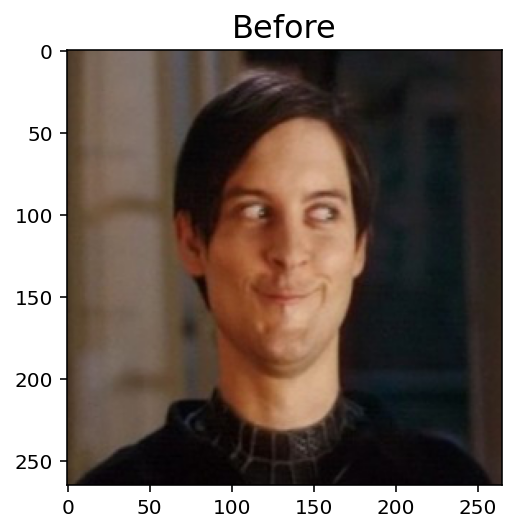

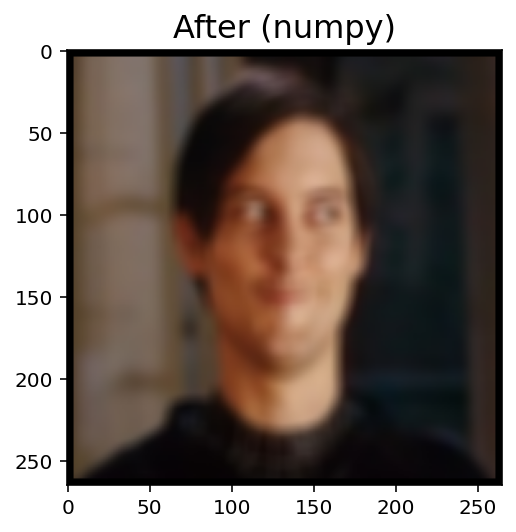

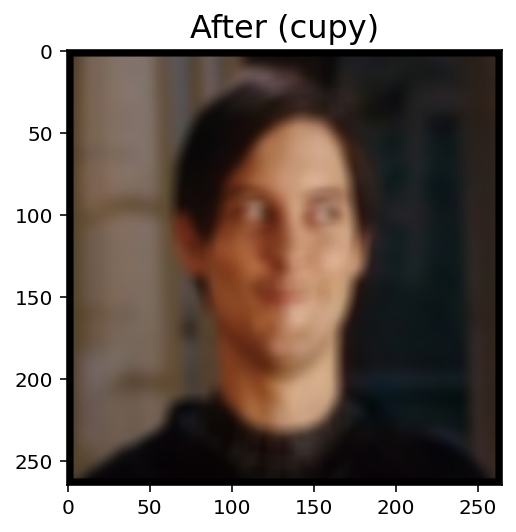

In [6]:
plt.title('Before', fontsize=16)
plt.imshow(image)
plt.show()

plt.title('After (numpy)', fontsize=16)
plt.imshow(np_blurred.astype(np.uint8))
plt.show()

plt.title('After (cupy)', fontsize=16)
plt.imshow(cp.asnumpy(cp_blurred).astype(np.uint8))
plt.show()

In [7]:
np_time = %timeit -o -q -n 100 np.stack([np_blur(np_parted_image[..., i], np_kernel) for i in range(3)])
np_time

<TimeitResult : 35.5 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [8]:
cp_time = %timeit -o -q -n 100 cp.stack([cp_blur(cp_parted_image[..., i], cp_kernel) for i in range(3)])
cp_time

<TimeitResult : 14.3 ms ± 5.69 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [9]:
np_time.average, cp_time.average, np_time.average / cp_time.average

(0.03549790278571891, 0.014325968677169709, 2.477871031666391)

Speedup of more than 2 times achieved